### Notebook to examine salary information of law professors in Ontario, using Sunshine List

Must first run scrape_bios.ipynb, then parse_bios.ipynb.

### Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests

### Load and merge datasets

In [2]:
# Load sunshine list data
request = requests.get('https://www.ontario.ca/public-sector-salary-disclosure/pssd-assets/files/2021/tbs-pssd-compendium-salary-disclosed-2021-en-utf-8-2023-01-05.json')
df_sunshine = pd.read_json(request.text)

# simplify first and last names for matching
df_sunshine['last_simple'] = df_sunshine['Last Name'].str.replace('[.,]', ' ', regex=True).str.strip()
df_sunshine['last_simple'] = df_sunshine['last_simple'].str.replace('\’', ' ', regex=True).str.strip()
df_sunshine['last_simple'] = df_sunshine['last_simple'].str.replace('\'', ' ').str.strip()
df_sunshine['last_simple'] = df_sunshine['last_simple'].str.split(' ').str[-1].str.strip().str.lower()
df_sunshine['last_simple'] = df_sunshine['last_simple'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
# Remove single quotes of various formats from Employer
df_sunshine['first_simple'] = df_sunshine['First Name'].str.replace('[.,]', ' ', regex=True).str.strip()
df_sunshine['first_simple'] = df_sunshine['first_simple'].str.split(' ').str[0].str.strip().str.lower()
df_sunshine['first_simple'] = df_sunshine['first_simple'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
# Remove single quotes of various formats from Employer
df_sunshine['Employer'] = df_sunshine['Employer'].str.replace('\’', '', regex=True).str.strip()
df_sunshine

,Sector,Last Name,First Name,Salary,Benefits,Employer,Job Title,Year,last_simple,first_simple
0,Colleges,Abboud,Nadim,116977.21,126.77,Algonquin College Of Applied Arts and Technology,Professor,2021,abboud,nadim
1,Colleges,Agate,Jeffrey,138280.53,392.33,Algonquin College Of Applied Arts and Technology,Associate Director Student Support Services,2021,agate,jeffrey
2,Colleges,Al Dabbah,Rayan,107206.59,21.77,Algonquin College Of Applied Arts and Technology,Professor,2021,dabbah,rayan
3,Colleges,Alexander,Doug,115377.97,126.77,Algonquin College Of Applied Arts and Technology,Professor,2021,alexander,doug
4,Colleges,Alexander,Tamra,116834.24,74.36,Algonquin College Of Applied Arts and Technology,Professor,2021,alexander,tamra
...,...,...,...,...,...,...,...,...,...,...
244451,Universities,Zikic,Jelena,239448.12,1022.64,York University,Associate Professor / Graduate Program Director,2021,zikic,jelena
244452,Universities,Zoidl,"Georg, R",232680.24,1065.36,York University,Professor,2021,zoidl,georg
244453,Universities,Zryd,Michael,176267.22,940.20,York University,Associate Professor / Graduate Program Director,2021,zryd,michael
244454,Universities,Zwick,Detlev,354142.06,1065.36,York University,Dean / Associate Professor,2021,zwick,detlev


In [3]:
# Load faculty bios from json
df = pd.read_json('data/all_bios_parsed.json')

# Clean data for matching with sunshine list

# rename universities to match sunshine list
universities = {
    'osgoode': 'York University',
    'u_toronto': 'University Of Toronto',
    'tmu': 'Ryerson University',
    'queens': 'Queens University',
    'western': 'University Of Western Ontario',
    'windsor': 'University Of Windsor',
    'uottawa-common': 'University Of Ottawa',
    'uottawa-civil': 'University Of Ottawa',
    'lakehead': 'Lakehead University',

    }
df['university'] = df['faculty'].apply(lambda x: universities[x])

# simplify first and last names for matching
df['name_simple'] = df['name'].str.replace('[.,]', ' ', regex=True).str.strip()
df['name_simple'] = df['name_simple'].str.replace('’', ' ', regex = True).str.strip()
df['name_simple'] = df['name_simple'].str.replace('\'', ' ').str.strip()
df['last_name'] = df['name_simple'].apply(lambda x: x.split(' ')[-1]).str.strip().str.lower()
df['first_name'] = df['name_simple'].apply(lambda x: x.split(' ')[0]).str.strip().str.lower()
df['last_name'] = df['last_name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df['first_name'] = df['first_name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# Manual changes do to variations in names
df.loc[df['name'] == 'Jonathon Penney', 'first_name'] = 'jon'
df.loc[df['name'] == 'Jim Phillips', 'first_name'] = 'james'
df.loc[df['name'] == 'Timothy J. Bartkiw', 'first_name'] = 'tim'
df.loc[df['name'] == 'Sharry Aiken', 'first_name'] = 'sharryn'
df.loc[df['name'] == 'Will Kymlicka', 'first_name'] = 'william'
df.loc[df['name'] == 'Chi Carmody', 'first_name'] = 'chios'
df.loc[df['name'] == 'Akis Psygkas', 'first_name'] = 'athanasios'
df.loc[df['name'] == 'Jeff Berryman', 'first_name'] = 'jeffrey'
df.loc[df['name'] == 'Patricia Galvão Ferreira', 'last_name'] = 'galvao-ferreira'
df.loc[df['name'] == 'Tess Sheldon', 'first_name'] = 'c'
df.loc[df['name'] == 'Yin-Yuan Chen', 'first_name'] = 'yin'
df.loc[df['name'] == 'P M Vasudev', 'first_name'] = 'palladam'
df.loc[df['name'] == 'Marel Katsivela', 'first_name'] = 'maria'
df.loc[df['name'] == 'John Packer', 'first_name'] = 'frederick'
df.loc[df['name'] == 'Muriel Paradelle', 'first_name'] = 'murielle'

print(df.university.value_counts())

#df


University Of Ottawa             112
York University                   63
University Of Toronto             62
Queens University                 39
University Of Western Ontario     39
University Of Windsor             34
Ryerson University                21
Lakehead University               14
Name: university, dtype: int64


### Merge datasets

In [4]:
# Merge df_sunshine and df using last_name, first_name and university from df, and Employer, Last Name and First Name from df_sunshine

df_merged = df.merge(df_sunshine, left_on=['last_name', 'first_name', 'university'], right_on=['last_simple', 'first_simple', 'Employer'])

# rename university values
universities = {
    'University Of Ottawa':'Ottawa',
    'York University': 'Osgoode',
    'University Of Toronto': 'Toronto',
    'Queens University': 'Queens',
    'University Of Western Ontario':'Western',
    'University Of Windsor':'Windsor',
    'Ryerson University': 'Lincoln Alexander',
    'Lakehead University': 'Lakehead'
    }

df_merged['university'] = df_merged['university'].apply(lambda x: universities[x])

# change column 'Job Title' to 'title_sunshine'

df_merged = df_merged.rename(columns={'Job Title': 'Title'})

# keep only needed columns
df_merged = df_merged[['name', 'university', 'faculty', 'href', 'bio', 'extracted_research_areas', 'Title', 'Salary' ]]

# Remove uottawa-civil
df_merged = df_merged[df_merged['faculty'] != 'uottawa-civil']

print(df_merged.university.value_counts())

#print number in df but not in df_merged
print()
print('Num in df but not in df_merged:')
print(len(df) - len(df_merged))
print()
df_merged


Ottawa               66
Osgoode              55
Toronto              52
Queens               37
Western              30
Windsor              27
Lincoln Alexander    14
Lakehead             11
Name: university, dtype: int64

Num in df but not in df_merged:
92



,name,university,faculty,href,bio,extracted_research_areas,Title,Salary
0,Saptarishi Bandopadhyay,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,I am an Associate Professor at Osgoode Hall La...,"[Environmental Law, International Law, Legal H...",Assistant Professor,139560.24
1,Stephanie Ben-Ishai,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Stephanie Ben-Ishai is a Distinguish...,"[Banking Law, Bankruptcy and Insolvency, Comme...",Professor,248584.79
2,Benjamin L. Berger,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Benjamin L. Berger is Professor and ...,"[Constitutional Law, Criminal Law, Evidence, L...",Professor,232562.47
3,Kate Glover Berger,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Kate Glover Berger joined the facult...,"[Administrative Law, Constitutional Law, Publi...",Assistant Professor,115342.67
4,Faisal Bhabha,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Faisal Bhabha is an Associate Professor at Osg...,"[Access to Justice, Administrative Law, Anti-D...",Associate Professor,171136.45
...,...,...,...,...,...,...,...,...
287,Darren O'Toole,Ottawa,uottawa-common,https://www.uottawa.ca/faculty-law/common-law/...,"Professor O’Toole teaches Aboriginal Law, Indi...","[Aboriginal Law, Indigenous Law, Legal Philoso...",Professeur(e) agrégé(e) / Associate Professor,134198.40
288,Alain Roussy,Ottawa,uottawa-common,https://www.uottawa.ca/faculty-law/common-law/...,Alain Roussy is currently Vice-Dean of the Fre...,"[Access to Justice, Employment Law, Labour Law...",Doyen(ne) / Dean,186071.20
289,Teresa Scassa,Ottawa,uottawa-common,https://www.uottawa.ca/faculty-law/common-law/...,Dr. Teresa Scassa is the Canada Research Chair...,"[Intellectual Property, Law and Technology, Pr...",Chaire de recherche du Canada / Canada Researc...,217335.76
290,Stéphane Sérafin,Ottawa,uottawa-common,https://www.uottawa.ca/faculty-law/common-law/...,Stéphane Sérafin is a graduate of the Programm...,"[Aboriginal Law, Commercial Law, Civil Litigat...",Professeur(e) adjoint(e) / Assistant Professor,106224.96


In [7]:
# Show professors in df but not df_merged
df_missing = df[~df['name'].isin(df_merged['name'])]
df_missing

,faculty,name,title,email,href,bio,listed_research_areas,extracted_research_areas,university,name_simple,last_name,first_name
0,osgoode,Rabiat Akande,Assistant Professor,rakande@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Rabiat Akande works in the fields of...,"[Legal History, Law and Religion, Constituti...","[Comparative Law, Constitutional Law, Internat...",York University,Rabiat Akande,akande,rabiat
10,osgoode,Suzanne Chiodo,Assistant Professor,schiodo@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Suzanne Chiodo’s areas of teaching a...,"[Civil Procedure, Access to Justice, Class A...","[Civil Procedure, Class Actions, Access to Jus...",York University,Suzanne Chiodo,chiodo,suzanne
11,osgoode,Barnali Choudhury,"Professor and Director, Jack & Mae Nathanson C...",bchoudhury@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Barnali Choudhury is a Professor of Law and th...,"[Corporate Law, Business and Human Rights, C...","[Corporate Law, Corporate Governance, Corporat...",York University,Barnali Choudhury,choudhury,barnali
15,osgoode,Signa A. Daum Shanks,Associate Professor,sdaumshanks@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Signa A. Daum Shanks started at Osgoode in 201...,"[Law and Economics, indigenous Governance, L...","[Aboriginal Law, Law and Economics, Legal Hist...",York University,Signa A Daum Shanks,shanks,signa
16,osgoode,Valerio De Stefano,Canada Research Chair in Innovation Law and So...,vdestefano@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,"Professor Valerio De Stefano, PhD, joined Osgo...","[Labour Law, Employment Law, Law and Technol...","[Labour Law, Employment Law, Law and Technolog...",York University,Valerio De Stefano,stefano,valerio
...,...,...,...,...,...,...,...,...,...,...,...,...
378,uottawa-civil,Jennifer Quaid,Professeure agrégée et vice-doyenne à la reche...,Jennifer.Quaid@uottawa.ca,https://www.uottawa.ca/faculte-droit/droit-civ...,Jennifer Quaid est professeure agrégée et vice...,None,"[Criminal Law, Competition Law, Corporate Gove...",University Of Ottawa,Jennifer Quaid,quaid,jennifer
379,uottawa-civil,David Robitaille,Professeur titulaire,david.robitaille@uottawa.ca,https://uniweb.uottawa.ca/members/1670/profile,David Robitaille est professeur titulaire à la...,None,"[Administrative Law, Constitutional Law, Envir...",University Of Ottawa,David Robitaille,robitaille,david
380,uottawa-civil,Terry Skolnik,Professeur agrégé,tskolnik@uottawa.ca,https://uniweb.uottawa.ca/members/4305/profile,Terry Skolnik is an associate professor (tenur...,None,"[Criminal Law, Criminal Procedure, Policing, P...",University Of Ottawa,Terry Skolnik,skolnik,terry
381,uottawa-civil,Marie-Eve Sylvestre,"Doyenne, professeure titulaire",Marie-Eve.Sylvestre@uottawa.ca,https://www.uottawa.ca/faculte-droit/droit-civ...,Marie-Eve Sylvestre est doyenne et professeure...,None,"[Criminal Law, Poverty Law, Housing, Sexuality...",University Of Ottawa,Marie-Eve Sylvestre,sylvestre,marie-eve


In [5]:
# Save merged data to json
df_merged.to_json('data/ontario_bios_w_salaries.json')

### Analysis of salaries of Toronto law professors

In [9]:
# Read merged data
df_merged = pd.read_json('data/ontario_bios_w_salaries.json')

# restrict to Toronto faculty
toronto_faculties = ['Toronto', 'Osgoode', 'Lincoln Alexander']
df_merged = df_merged[df_merged['university'].isin(toronto_faculties)]

In [10]:
# get average Salary for each university in df_merged
print ('Mean Salary by University')
print(df_merged.groupby('university')['Salary'].mean())
print()
print ('Median Salary by University')
print(df_merged.groupby('university')['Salary'].median())
print()
print ('-------------------------')
print()


# create new df with only pronouns and salary, and print value counts
df_pronouns = df_merged.copy()
print ('Pronouns used in bios')
print(df_pronouns.value_counts('pronouns'))
print()
print ('-------------------------')
print()

# Remove 'other' because this means no pronouns used in bio (e.g. first person or bio missing)
df_pronouns = df_pronouns[df_pronouns['pronouns'] != 'other']

# Note: No they/them pronouns used in any bios

# get mean and median salary for each pronoun
print('Mean Salary by Pronouns')
print(df_pronouns.groupby('pronouns')['Salary'].mean())
print()
print ('Median Salary by Pronouns')
print(df_pronouns.groupby('pronouns')['Salary'].median())
print()
print ('-------------------------')
print()

# get median salary for each pronoun, per university 
print('Mean Salary by Pronouns and University')
print(df_pronouns.groupby(['university', 'pronouns'])['Salary'].mean())
print()
print('Median Salary by Pronouns and University')
print(df_pronouns.groupby(['university', 'pronouns'])['Salary'].median())




Mean Salary by University
university
Lincoln Alexander    177123.845714
Osgoode              208585.456364
Toronto              248598.171731
Name: Salary, dtype: float64

Median Salary by University
university
Lincoln Alexander    174953.595
Osgoode              209695.770
Toronto              240436.975
Name: Salary, dtype: float64

-------------------------

Pronouns used in bios
pronouns
he/him     62
she/her    57
other       2
dtype: int64

-------------------------

Mean Salary by Pronouns
pronouns
he/him     229750.853710
she/her    216321.293333
Name: Salary, dtype: float64

Median Salary by Pronouns
pronouns
he/him     210092.985
she/her    218815.440
Name: Salary, dtype: float64

-------------------------

Mean Salary by Pronouns and University
university         pronouns
Lincoln Alexander  he/him      175398.265000
                   she/her     178418.031250
Osgoode            he/him      213979.334348
                   she/her     206810.166774
Toronto            he/him 

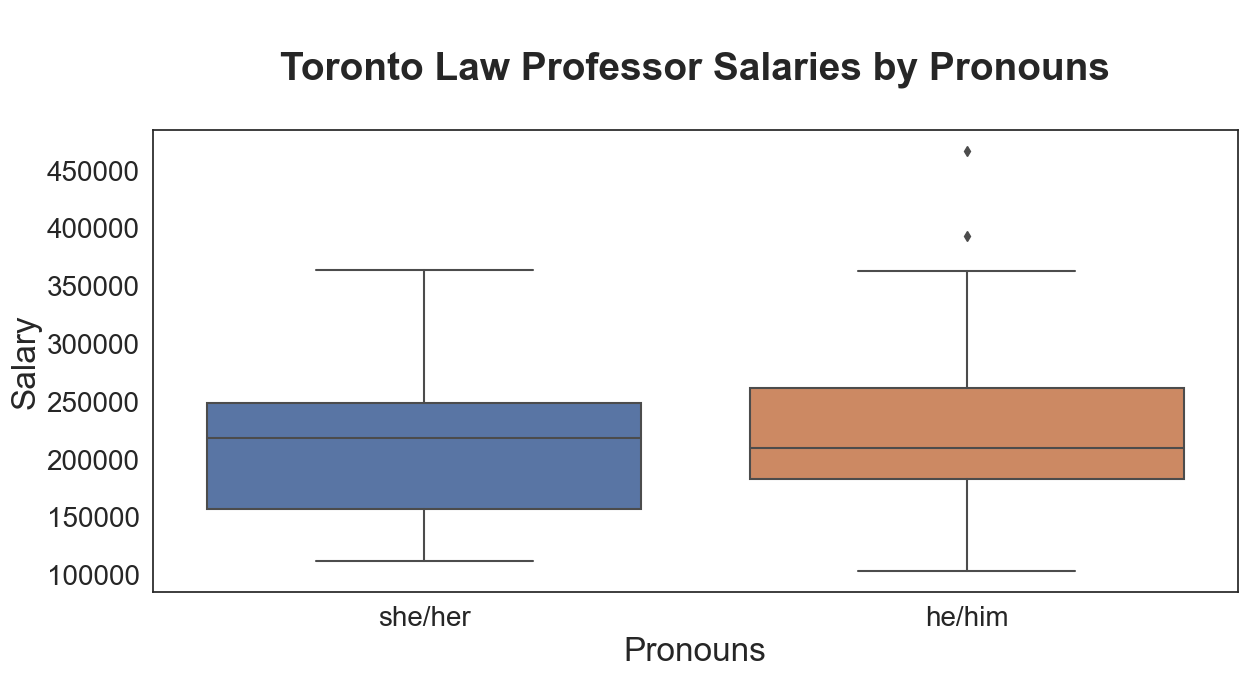

In [11]:
# graph the distribution of salaries for each pronoun
sns.set_palette('husl')
sns.set_theme(style="white")
ax = sns.boxplot(x="pronouns", y="Salary", data=df_pronouns)
ax.set_title('\nToronto Law Professor Salaries by Pronouns\n', fontweight='bold', fontsize=28)
ax.set_xlabel('Pronouns', fontsize=24)
ax.set_ylabel('Salary', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().set_size_inches(14, 6)
plt.show()

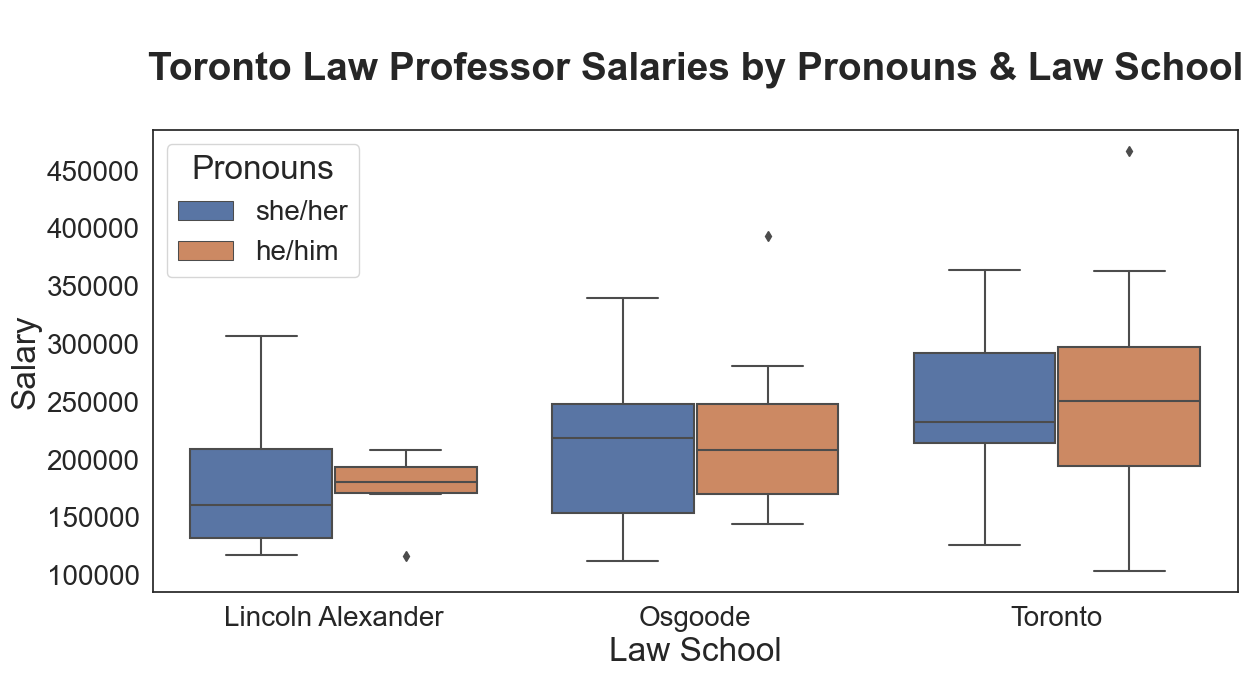

In [12]:
# graph the distribution of salaries for each pronoun, broken down by university
sns.set_theme(style="white")
university_order = df_pronouns['university'].sort_values().unique()
ax = sns.boxplot(x="university", y="Salary", hue="pronouns", data=df_pronouns, order=university_order)
ax.set_title('\nToronto Law Professor Salaries by Pronouns & Law School\n', fontweight='bold', fontsize=28)
ax.set_xlabel('Law School', fontsize=24)
ax.set_ylabel('Salary', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().set_size_inches(14, 6)
ax.legend(title='Pronouns', fontsize=20, title_fontsize=24)
plt.show()

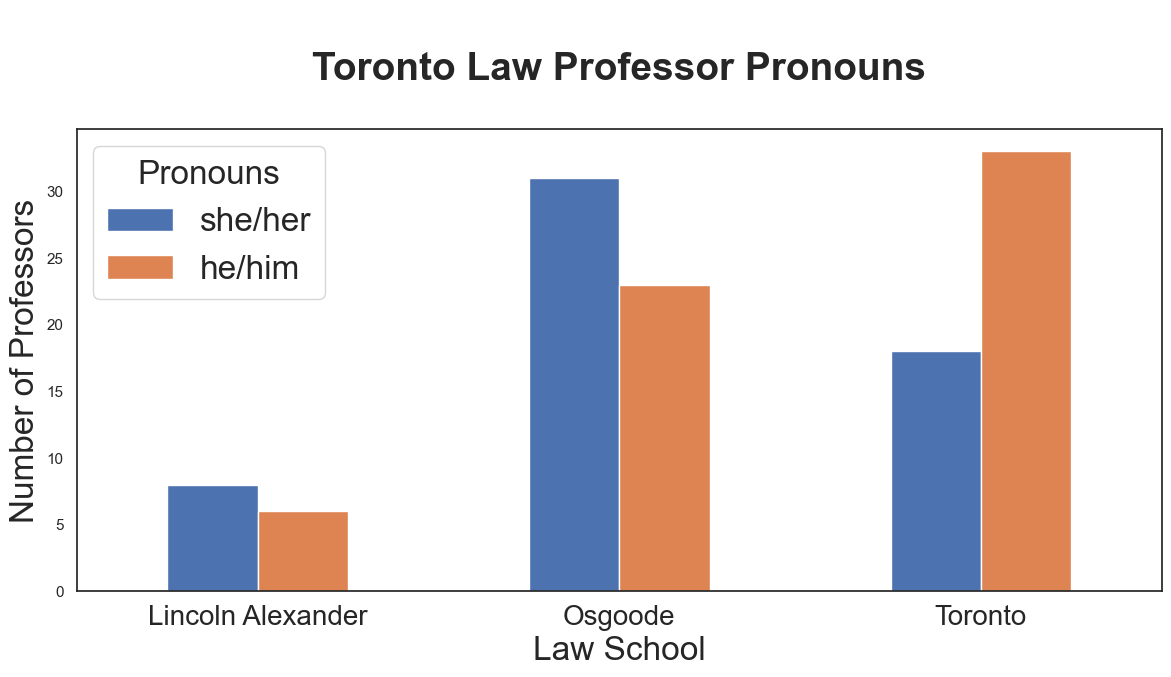

In [13]:
# modify the order of the columns in the DataFrame so that pronouns appear in same order as in the boxplots
df_pronouns = df_pronouns.pivot_table(index='university', columns='pronouns', aggfunc='size')
df_pronouns = df_pronouns[['she/her', 'he/him']]

# bar chart with the number of professors with each pronoun, broken down by university
sns.set_palette('husl')
sns.set_theme(style="white")
df_pronouns.plot(kind='bar', stacked=False)
plt.xlabel('Law School', fontsize=24)
plt.ylabel('Number of Professors', fontsize=24)
plt.xticks(rotation=0, ha='center', fontsize=20)
plt.gcf().set_size_inches(14, 6)
plt.title('\nToronto Law Professor Pronouns\n', fontweight='bold', fontsize=28)
plt.legend(title='Pronouns', fontsize=24, title_fontsize=24)
plt.show()

### Individual Schools

In [14]:
df_merged[df_merged['university']== 'Osgoode'].sort_values('Salary', ascending=False)

,name,university,faculty,href,bio,extracted_research_areas,Title,Salary,pronouns
21,Steven Hoffman,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Dr. Steven J. Hoffman is the Dahdaleh Distingu...,"[Bioethics, Health Law, Intellectual Property,...",Professor / Canada Research Chair,393706.24,he/him
37,Lisa Philipps,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Lisa Philipps teaches and writes abo...,"[Tax Law, Disability Law, Family Law, Pensions]",Provost and Vice President Academic / Professor,339999.92,she/her
9,Mary G. Condon,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Mary Condon was appointed Dean of Osgoode Hall...,"[Corporate Law, Feminist Legal Theory, Pension...",Dean / Professor,322832.40,she/her
25,Jinyan Li,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Jinyan Li is Professor of Tax Law and former I...,[Tax Law],Professor,290030.97,she/her
22,Allan C. Hutchinson,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,"A member of Osgoode’s faculty since 1982, Prof...","[Constitutional Law, Torts, Jurisprudence, Civ...",Professor,280734.71,he/him
39,Poonam Puri,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Poonam Puri is an internationally re...,"[Banking Law, Corporate Governance, Corporate ...",Professor / Course Director,274011.45,she/her
17,Benjamin Geva,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Dr. Benjamin Geva is a Professor of Law at Osg...,"[Banking Law, Commercial Law, Comparative Law,...",Professor,271502.64,he/him
16,Trevor C. W. Farrow,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Research. Professor Farrow is internationally ...,"[Access to Justice, Civil Procedure, Dispute R...",Professor,270242.91,he/him
18,Philip Girard,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Philip Girard joined the faculty of Osgoode Ha...,"[Legal History, Indigenous Law, Constitutional...",Professor,261871.21,he/him
43,Craig M. Scott,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,"As of July 2021, Professor Craig Scott is serv...","[Constitutional Law, International Law, Intern...",Associate Dean / Professor,260568.27,he/him


In [15]:
df_merged[df_merged['university']== 'Lincoln Alexander'].sort_values('Salary', ascending=False)

,name,university,faculty,href,bio,extracted_research_areas,Title,Salary,pronouns
120,Donna Young,Lincoln Alexander,tmu,https://www.torontomu.ca/law/about/our-dean/,Donna E. Young is the Founding Dean of the Lin...,"[Academic Freedom, Anti-Discrimination, Crimin...",Dean,306884.04,she/her
116,Pnina Alon-Shenker,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Pnina Alon-Shenker is an associate professor i...,"[Employment Law, Labour Law, Human Rights Law,...",Associate Professor,218323.40,she/her
114,Avner Levin,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Avner Levin is a professor at Toronto Metropol...,"[Law and Technology, Privacy Law]",Professor,208227.48,he/him
110,Sari Graben,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Sari Graben’s teaching and research focuses on...,"[Aboriginal Law, Environmental Law, Gender and...",Associate Dean Research and Graduate Studies,206669.39,she/her
115,Asher Alkoby,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Asher Alkoby is an associate professor in the ...,"[Corporate Social Responsibility, Law and Soci...",Associate Professor,195318.40,he/him
117,Timothy J. Bartkiw,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Timothy J. Bartkiw is an associate professor i...,"[Employment Law, Labour Law, Comparative Law]",Associate Professor,187631.46,he/him
119,Alexandra Orlova,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Alexandra Orlova received her PhD in law from ...,"[Criminal Law, International Criminal Law, Hum...",Professor,175599.41,she/her
118,Gil Lan,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Gil Lan is an associate professor in the Linco...,"[Business Associations, Comparative Law, Corpo...",Associate Professor,174307.78,he/him
112,Graham Hudson,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Graham Hudson is an Associate Professor and As...,"[Access to Justice, Constitutional Law, Crimin...",Associate Dean,170246.16,he/him
107,Idil Atak,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Dr. Idil Atak is an associate professor at the...,"[Human Rights Law, Immigration and Refugee Law...",Chair Criminology,145694.75,she/her


In [16]:

df_merged[df_merged['university']== 'Toronto'].sort_values('Salary', ascending=False)

,name,university,faculty,href,bio,extracted_research_areas,Title,Salary,pronouns
66,Alexander Dyck,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,Professor of Finance and Economic Analysis and...,"[Corporate Governance, Corporate Law, Corporat...",Professor of Finance,466599.00,he/him
58,Jutta Brunnée,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,"Dean, University Professor & James Marshall To...","[Environmental Law, International Environmenta...",Dean and Professor of Law,363826.50,she/her
74,Edward Iacobucci,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,Professor & TSE Chair in Capital Markets Jackm...,"[Competition Law, Corporate Law, Law and Econo...","Professor of Law and Dean, Faculty of Law",363082.48,he/him
91,Cheryl Regehr,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,Vice-President and Provost Simcoe Hall 27 King...,"[Civil Litigation, Criminal Law, Health Law]","Vice President and Provost; Professor, Factor-...",358000.02,she/her
92,Arthur Ripstein,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,"Professor of Law and Philosophy, University Pr...","[Legal Philosophy, Political Philosophy, Torts]",Professor of Law and cross-appointed to Philos...,354357.42,he/him
94,Kent Roach,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,Professor Jackman Law BuildingRoom J446 78 Que...,"[Charter of Rights and Freedoms, Comparative L...",Professor of Law,345612.54,he/him
105,Stephen Waddams,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,Professor Jackman Law Building78 Queen's ParkT...,"[Contracts, Legal History]",Professor of Law,334294.98,he/him
78,Brian Langille,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,Professor Jackman Law BuildingRoom J45478 Quee...,"[Charter of Rights and Freedoms, Contracts, In...",Professor of Law,327335.04,he/him
73,Gillian Hadfield,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,Schwartz Reisman Chair in Technology and Socie...,"[Artificial Intelligence, Computational Law, C...",Professor of Law,326412.92,she/her
67,David Dyzenhaus,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,University Professor of Law and Philosophy and...,"[Administrative Law, Comparative Law, Legal Ph...",Professor of Law and cross-appointed to Philos...,318360.26,he/him


### Visualize Ontario

NOTE: Not currently working for U Ottawa, because of (a) missing bios and (b) french bios that get categorized as pronouns other.

CONSIDER: creating a new script to look for pronouns in the french bios, though that is more complicated and in some places requires inferences 

OR

Remove Ottawa Civil Law from the mix, and make this about common law schools in Ontario.



In [17]:
# Read merged data
df_merged = pd.read_json('data/ontario_bios_w_salaries.json')

In [18]:
# get average Salary for each university in df_merged
print ('Mean Salary by University')
print(df_merged.groupby('university')['Salary'].mean())
print()
print ('Median Salary by University')
print(df_merged.groupby('university')['Salary'].median())
print()
print ('-------------------------')
print()


def get_pronouns(text):

    if not text:
        return "other"

    # Create a dictionary to keep track of the count of each pronoun
    pronoun_count = {"he": 0, "him": 0, "his": 0, "she": 0, "her": 0, "hers": 0, "they": 0, "them": 0, "their": 0, "theirs": 0}

    # prepare the text for analysis
    text = text.lower().split()

    # count the pronouns
    for word in text:
        if word in pronoun_count:
            pronoun_count[word] += 1

    # if no pronouns, return "other"
    if sum(pronoun_count.values()) == 0:
        return "other"

    # Get the most common pronouns
    most_common_pronoun = max(pronoun_count, key=pronoun_count.get)
    if most_common_pronoun in ["he", "him", "his"]:
        return "he/him"
    elif most_common_pronoun in ["she", "her", "hers"]:
        return "she/her"
    else:
        return "they/them"

# get pronouns for each bio using apply
df_merged['pronouns'] = df_merged['bio'].apply(get_pronouns)

# fix two pronouns 
df_merged.loc[df_merged['name'] == 'Ravi Malhotra', 'pronouns'] = 'he/him'  # error caused by French, but pronouns used in en bio
df_merged.loc[df_merged['name'] == 'Michael Geist', 'pronouns'] = 'he/him' # error caused by French, but pronouns used in en bio
df_merged.loc[df_merged['name'] == 'Ellen Zweibel', 'pronouns'] = 'other' # first person

# NOT FIXED BECAUSE NO PRONOUNS AVAILABLE
# Saptarishi Bandopadhyay No pronouns used in bio
# Peter Cziraki No bio
# Patricia Peppin First person
# Ruth Kuras No bio
# Margaret Liddle No bio
# Lisa Trabucco No bio
# Jula Hughes No pronouns used in bio
# Amir Attaran No pronouns used in bio
# Jeremy De Beer first person
# Sylvia Rich first person
# Penelope Simons first person
# LIST DOES NOT INCLUDE OTTAWA CIVIL LAW

# create new df with only pronouns and salary, and print value counts
df_pronouns = df_merged.copy()
print ('Pronouns used in bios')
print(df_pronouns.value_counts('pronouns'))
print()
print ('-------------------------')
print()

# Remove 'other' because this means no pronouns used in bio (e.g. first person or bio missing)
df_pronouns = df_pronouns[df_pronouns['pronouns'] != 'other']

# Note: No they/them pronouns used in any bios

# get mean and median salary for each pronoun
print('Mean Salary by Pronouns')
print(df_pronouns.groupby('pronouns')['Salary'].mean())
print()
print ('Median Salary by Pronouns')
print(df_pronouns.groupby('pronouns')['Salary'].median())
print()
print ('-------------------------')
print()

# get median salary for each pronoun, per university 
print('Mean Salary by Pronouns and University')
print(df_pronouns.groupby(['university', 'pronouns'])['Salary'].mean())
print()
print('Median Salary by Pronouns and University')
print(df_pronouns.groupby(['university', 'pronouns'])['Salary'].median())



Mean Salary by University
university
Lakehead             146787.237273
Lincoln Alexander    177123.845714
Osgoode              208585.456364
Ottawa               171127.478485
Queens               183372.249730
Toronto              248598.171731
Western              165222.516333
Windsor              155090.294074
Name: Salary, dtype: float64

Median Salary by University
university
Lakehead             123650.310
Lincoln Alexander    174953.595
Osgoode              209695.770
Ottawa               170006.620
Queens               180806.330
Toronto              240436.975
Western              165087.990
Windsor              147437.930
Name: Salary, dtype: float64

-------------------------

Pronouns used in bios
pronouns
he/him     152
she/her    128
other       12
dtype: int64

-------------------------

Mean Salary by Pronouns
pronouns
he/him     194351.310197
she/her    188888.987187
Name: Salary, dtype: float64

Median Salary by Pronouns
pronouns
he/him     185017.775
she/her    175

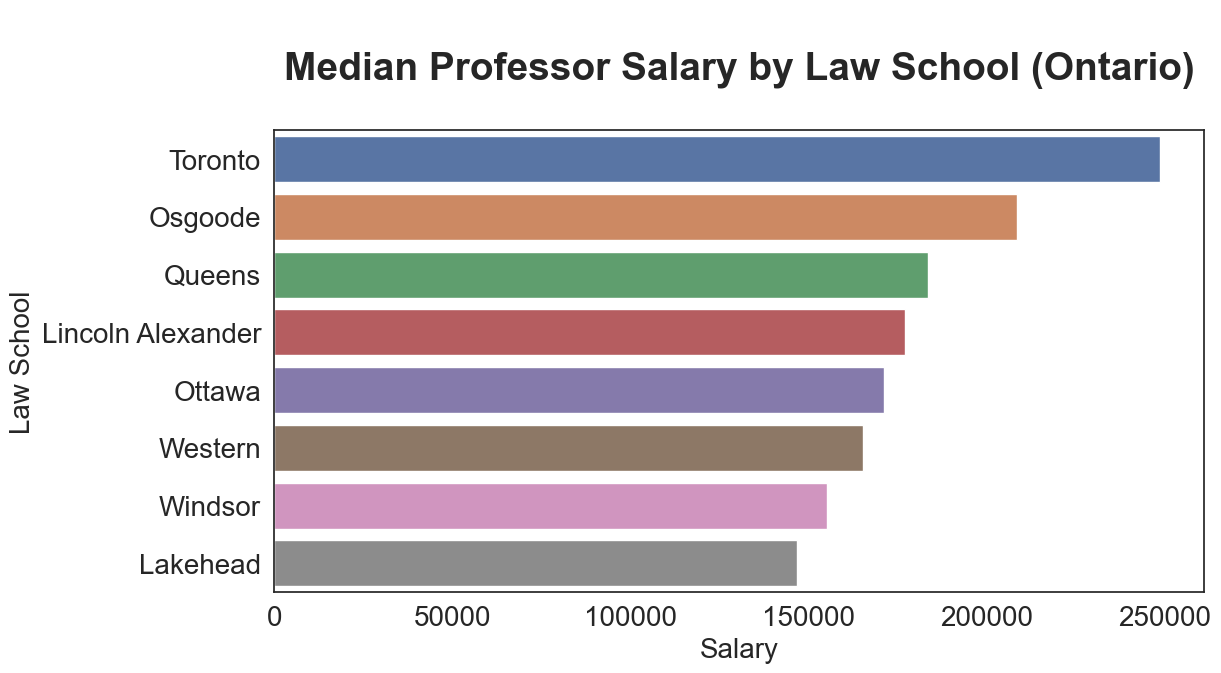

In [19]:
# bar chart with median salary for each university, with univerity as y axis (sorted by salary) and salary as x axis
sns.set_palette('Blues_d')
sns.set_theme(style="white")
ax = sns.barplot(x="Salary", y="university", data=df_merged, order=df_merged.groupby('university')['Salary'].median().sort_values(ascending=False).index, errorbar=None)
ax.set_title('\nMedian Professor Salary by Law School (Ontario)\n', fontweight='bold', fontsize=28)
ax.set_xlabel('Salary', fontsize=20)
ax.set_ylabel('Law School', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().set_size_inches(12, 6)
plt.show()


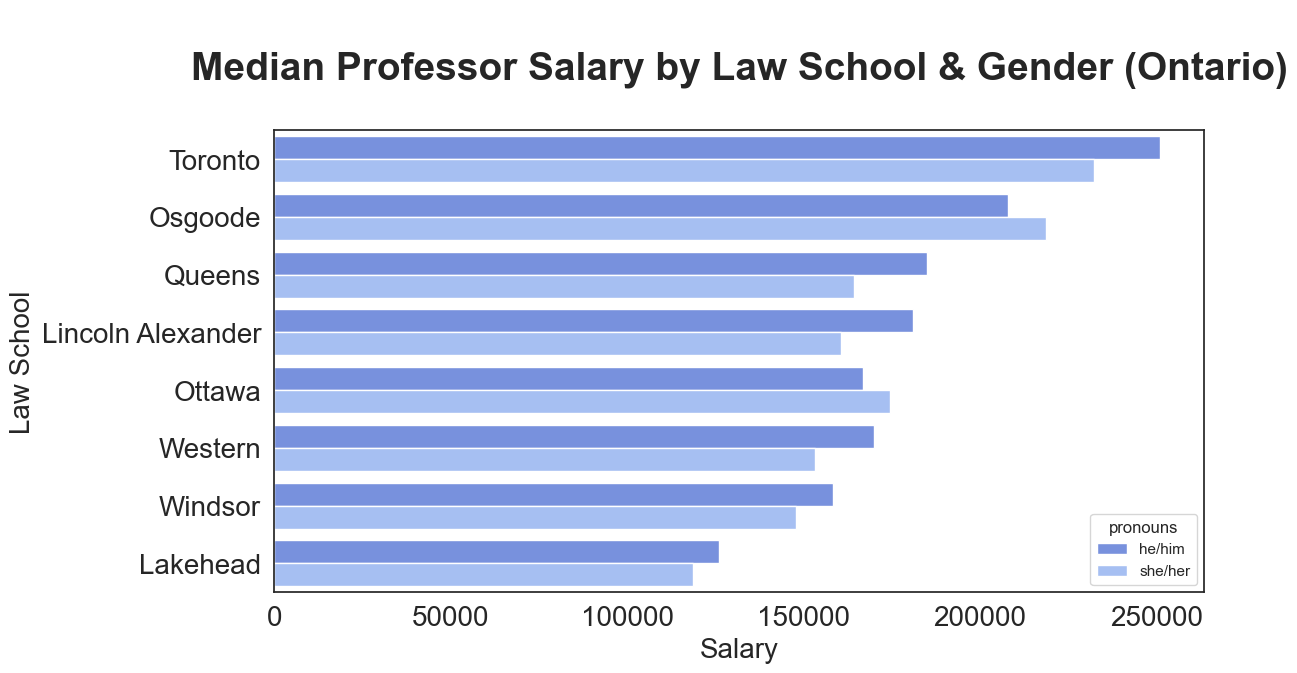

In [20]:
# groupby to get university and pronouns, then get the median salary for each group
df_grouped = df_pronouns.groupby(['university', 'pronouns'])['Salary'].median().reset_index()
df_grouped

#make bar chart from df_grouped
sns.set_theme(style="white")
sns.set_palette('coolwarm')
ax = sns.barplot(x="Salary", y="university", hue="pronouns", data=df_grouped, order=df_grouped.groupby('university')['Salary'].median().sort_values(ascending=False).index, errorbar=None)
ax.set_title('\nMedian Professor Salary by Law School & Gender (Ontario)\n', fontweight='bold', fontsize=28)
ax.set_xlabel('Salary', fontsize=20)
ax.set_ylabel('Law School', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().set_size_inches(12, 6)
plt.show()


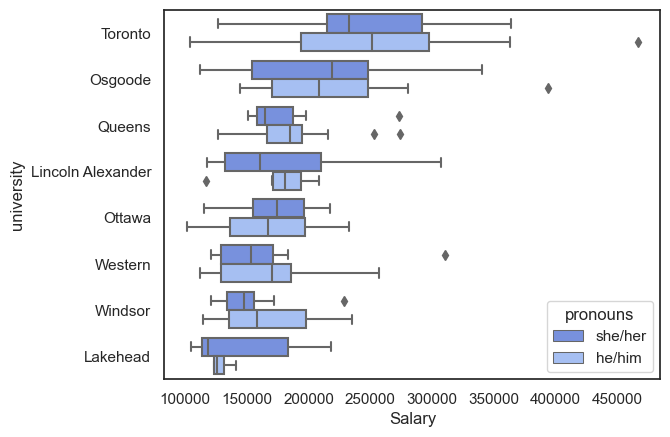

In [21]:
# Box plot of salary by university and pronouns, with univesrity as y axis
sns.set_theme(style="white")
sns.set_palette('coolwarm')
ax = sns.boxplot(x="Salary", y="university", hue="pronouns", data=df_pronouns, order=df_pronouns.groupby('university')['Salary'].median().sort_values(ascending=False).index)


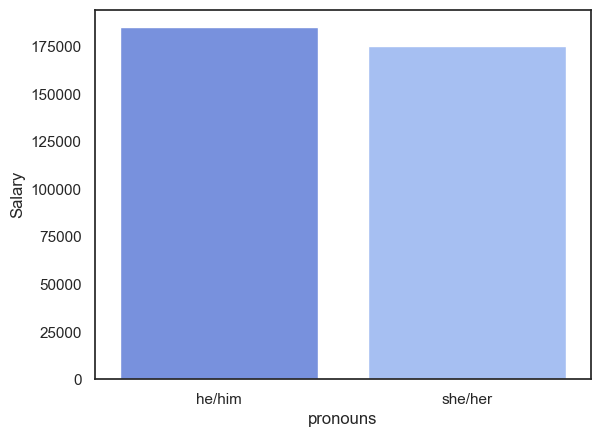

In [22]:
groupby = df_pronouns.groupby('pronouns')['Salary'].median().sort_values(ascending=False).reset_index()

# bar chart based on groupby, with pronouns as x asis
sns.set_theme(style="white")
sns.set_palette('coolwarm')
ax = sns.barplot(x="pronouns", y="Salary", data=groupby, errorbar=None)


### Salaries and research expertise

In [45]:
# get median salary for each item in list in df_merged.extracted_research_areas (handling none values)

df_expanded = df_merged.explode('extracted_research_areas')

# Calculate the median and count for each group
grouped_data = df_expanded.groupby('extracted_research_areas')['Salary'].agg(['mean', 'count']).reset_index()

# Sort the results by the median salary
sorted_data = grouped_data.sort_values(by='mean', ascending=False).reset_index(drop=True)

#reformat
sorted_data['mean'] = sorted_data['mean'].map('${:,.0f}'.format)
sorted_data = sorted_data.rename(columns={'mean': 'AVERAGE SALARY'})
sorted_data = sorted_data.rename(columns={'extracted_research_areas': 'RESEARCH AREA'})
sorted_data = sorted_data.rename(columns={'count': 'COUNT'})

# add title: Average law faculty salary by research area (Ontario)
print( 'Average law faculty salary by research area in Ontario \n           (research areas with 15+ faculty)\n')

# print sorted data filtering to include only count > 15, hide index
print(sorted_data[sorted_data['COUNT'] > 15].to_string(index=False))




Average law faculty salary by research area in Ontario 
           (research areas with 15+ faculty)

                 RESEARCH AREA AVERAGE SALARY  COUNT
             Law and Economics       $231,282     19
                 Corporate Law       $215,536     20
                  Legal Theory       $212,643     45
Charter of Rights and Freedoms       $206,015     21
                    Family Law       $203,410     17
                     Contracts       $203,252     29
                    Health Law       $201,528     19
                         Torts       $199,167     36
         Intellectual Property       $194,992     26
         Feminist Legal Theory       $194,642     24
               Comparative Law       $194,558     36
            Gender and the Law       $194,298     20
          Political Philosophy       $193,280     21
       Artificial Intelligence       $192,118     16
                    Public Law       $191,346     21
                 Legal History       $189,947     